# <center> Inflation Rate Forecasting <center>

### <center> Saurav Raj Khanal <center>

### Data Loading

- First, we begin by loading the dataset, which includes macroeconomic variables such as exchange rates, GDP, government revenue, foreign exchange reserves, and stock market indices. The data is gathered from various reliable sources to ensure accuracy. 


In [101]:
import pandas as pd
import numpy as np

exchange_rate: pd.DataFrame = pd.read_excel('data/macro-economic-indicators/Exchange-rate.xlsx')
gdp_data = pd.read_excel('data/macro-economic-indicators/GDP.xlsx')
government_revenue = pd.read_excel('data/macro-economic-indicators/Government-Revenue-and-Expenditure.xlsx')
inflation = pd.read_excel('data/macro-economic-indicators/Inflation.xlsx')
liquidity = pd.read_excel('data/macro-economic-indicators/Liquidity.xlsx')
interest_rate: pd.DataFrame = pd.read_excel('data/macro-economic-indicators/Nepal bank Base Interest Rate.xlsx')

### Data Pre-processing/ Cleaning

 After loading, we inspect the data structure and check for any missing values or anomalies. Here, We preprocess the data by cleaning it and preparing it for analysis. This includes handling missing values, converting data types where necessary, merging data and normalizing the data. 

1. for Exchange Rate

In [102]:
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# pre-processing exchange rate

exchange_rate['Year'] = exchange_rate['Year'].fillna(method='ffill')

exchange_rate['Year'] = exchange_rate['Year'].astype(str).apply(lambda x: x.split('/')[0])

exchange_rate['Month'] = exchange_rate['Month'].map(month_mapping)

exchange_rate = exchange_rate.dropna(subset=['Month'])

exchange_rate['Date'] = exchange_rate['Year'] + '-' + exchange_rate['Month'].astype(int).astype(str) + '-01'

exchange_rate['Date'] = pd.to_datetime(exchange_rate['Date'], format='%Y-%m-%d')

exchange_rate = exchange_rate[['Date', 'Rate']]
exchange_rate.rename(columns={'Rate': 'Exchange Rate'}, inplace=True)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5368\3164848343.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exchange_rate['Year'] = exchange_rate['Year'].fillna(method='ffill')


2. For GDP

In [103]:
new_gdp_data = []
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

for _, row in gdp_data.iterrows():
    year = int(row['Year'])
    for month in months:
        date = f"{year}-{int(month)}-01"
        new_row = [date] + row[1:].tolist()
        new_gdp_data.append(new_row)


new_gdp_data = pd.DataFrame(new_gdp_data, columns=['Date', 'GDP', 'Per Capita', 'Growth', 'Trade Balance (USD Billion)', '% of GDP', 'Contribution of Manufactoring Industry to GDP', 'No of People Going for Foreign Employment'])
new_gdp_data['Date'] = pd.to_datetime(new_gdp_data['Date'])

# Interpolate missing values linearly
new_gdp_data['GDP'] = new_gdp_data['GDP'].interpolate(method='linear')

# merge new_gdp_data and exchange_rate
exchange_rate_gdp_data = pd.merge(exchange_rate, new_gdp_data, on='Date', how='left')


3. For Government Revenue and Expenditure

In [104]:
# pre-processing government data
government_revenue = pd.read_excel('data/macro-economic-indicators/Government-Revenue-and-Expenditure.xlsx')
government_revenue.fillna(government_revenue.mean(), inplace=True)
government_revenue['Date'] = pd.to_datetime(government_revenue['Date'])
# Extract year and month from 'Date' for grouping
government_revenue['YearMonth'] = government_revenue['Date'].dt.to_period('M')

# Group by Year-Month and sum 'Total Receipts of GON' and 'Total Expenditure'
monthly_data = government_revenue.groupby('YearMonth').agg(
    Monthly_Income=pd.NamedAgg(column='Total Receipts of GON', aggfunc='sum'),
    Monthly_Expenditure=pd.NamedAgg(column='Total Expenditure', aggfunc='sum')
).reset_index()

# Convert YearMonth to first date of the month
monthly_data['Date'] = monthly_data['YearMonth'].dt.start_time

government_revenue = monthly_data[['Date', 'Monthly_Income', 'Monthly_Expenditure']]

# merge exchange_rate_gdp_data and government_revenue
exchange_rate_gdp_govermment_data = pd.merge(government_revenue, exchange_rate_gdp_data, on='Date', how='left')
exchange_rate_gdp_govermment_data.head()


,Date,Monthly_Income,Monthly_Expenditure,Exchange Rate,GDP,Per Capita,Growth,Trade Balance (USD Billion),% of GDP,Contribution of Manufactoring Industry to GDP,No of People Going for Foreign Employment
0,2021-07-01,283360.9,12701.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-08-01,3004465.2,400482.7,118.80,36.28883,1222.8788,4.2469,-12.117845,-33.3928,4.665598,50000.0
2,2021-09-01,5382410.0,2358148.0,117.59,36.28883,1222.8788,4.2469,-12.117845,-33.3928,4.665598,50000.0
3,2021-10-01,8406644.5,5903400.0,120.42,36.28883,1222.8788,4.2469,-12.117845,-33.3928,4.665598,50000.0
4,2021-11-01,10677412.8,8726185.2,119.18,36.28883,1222.8788,4.2469,-12.117845,-33.3928,4.665598,50000.0


4. For Inflation data

In [105]:
# inflation preprocessing
inflation = pd.read_excel('data/macro-economic-indicators/Inflation.xlsx')
inflation['Month'] = inflation['Month'].map(month_mapping)
inflation.dropna(inplace=True)
inflation['Date'] = inflation['Year'].astype(int).astype(str) + '-' + inflation['Month'].astype(int).astype(str) + '-01'
inflation['Date'] = pd.to_datetime(inflation['Date'], format='%Y-%m-%d')
inflation = inflation[['Date','Index','Change']]

# merge infaltion to above data
nepal_economy = exchange_rate_gdp_govermment_data.merge(inflation, on='Date', how='left')


5. For Liquidity dataset

In [106]:
# liquidity preprocessing

liquidity = pd.read_excel('data/macro-economic-indicators/Liquidity.xlsx')
liquidity['Date'] = pd.to_datetime(liquidity['Date'])

# Replace '-' with NaN and convert the columns to numeric
liquidity['Balance at NRB minus CRR'] = pd.to_numeric(
    liquidity['Balance at NRB minus CRR'].replace('-', pd.NA), errors='coerce')
liquidity['Prime Rate'] = pd.to_numeric(
    liquidity['Prime Rate'].replace('-', pd.NA), errors='coerce')
liquidity['Secondary Rate'] = pd.to_numeric(
    liquidity['Secondary Rate'].replace('-', pd.NA), errors='coerce')

# Extract Year-Month to group by month
liquidity.fillna(liquidity.mean(), inplace=True)
liquidity['YearMonth'] = liquidity['Date'].dt.to_period('M')

# Group by YearMonth and calculate monthly averages
liq_monthly_avg = liquidity.groupby('YearMonth').agg({
    'Balance at NRB minus CRR': 'mean',
    'Prime Rate': 'mean',
    'Secondary Rate': 'mean'
}).reset_index()

# Set Date as the first day of each month
liq_monthly_avg['Date'] = liq_monthly_avg['YearMonth'].dt.start_time

liq_monthly_avg = liq_monthly_avg[['Date', 'Balance at NRB minus CRR', 'Prime Rate', 'Secondary Rate']]
liq_monthly_avg.head()


#merge liquidity to nepal economy
nepal_economy = nepal_economy.merge(liq_monthly_avg, on='Date', how='left')

6. For Interest Rate Dataset

In [107]:

# preprocessing interest rate
interest_rate: pd.DataFrame = pd.read_excel('data/macro-economic-indicators/Nepal bank Base Interest Rate.xlsx')
#Melt the dataframe to convert months as rows
interest_rate = interest_rate.melt(id_vars=["FY"], var_name="Month", value_name="Interest Rate")

interest_rate['Date'] = pd.to_datetime(interest_rate['FY'].astype(str) + '-' + interest_rate['Month'] + '-01')

interest_rate = interest_rate[['Date', 'Interest Rate']]

# merge interest_rate to nepal economy
nepal_economy = nepal_economy.merge(interest_rate, on='Date', how='left')
nepal_economy.fillna(nepal_economy.mean(),inplace=True)



In [108]:
# using date as index

nepal_economy.set_index('Date', inplace=True)

nepal_economy.to_excel('data/merged_data.xlsx',index=False)

nepal_economy.head()

,Monthly_Income,Monthly_Expenditure,Exchange Rate,GDP,Per Capita,Growth,Trade Balance (USD Billion),% of GDP,Contribution of Manufactoring Industry to GDP,No of People Going for Foreign Employment,Index,Change,Balance at NRB minus CRR,Prime Rate,Secondary Rate,Interest Rate
Date,,,,,,,,,,,,,,,,
2021-07-01,283360.9,12701.9,125.087273,36.28883,1222.8788,4.2469,-12.117845,-33.3928,4.665598,50000.0,142.42,4.35,73177.185691,2.027138,2.795923,7.01
2021-08-01,3004465.2,400482.7,118.800000,36.28883,1222.8788,4.2469,-12.117845,-33.3928,4.665598,50000.0,142.40,3.49,27265.603242,3.477316,3.525055,6.83
2021-09-01,5382410.0,2358148.0,117.590000,36.28883,1222.8788,4.2469,-12.117845,-33.3928,4.665598,50000.0,143.42,4.24,22785.998293,4.684064,4.541698,6.81
2021-10-01,8406644.5,5903400.0,120.420000,36.28883,1222.8788,4.2469,-12.117845,-33.3928,4.665598,50000.0,146.54,6.04,29193.264593,4.456972,4.649000,6.70
2021-11-01,10677412.8,8726185.2,119.180000,36.28883,1222.8788,4.2469,-12.117845,-33.3928,4.665598,50000.0,146.09,7.11,18026.791357,4.533005,4.685647,6.38


### Data Normalization

In [109]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Initializing the scaler
scaler = StandardScaler()

# Scale all numerical columns
scaled_values = scaler.fit_transform(nepal_economy)

# Creating a new DataFrame with scaled values, keeping the index
df_scaled = pd.DataFrame(scaled_values, columns=nepal_economy.columns, index=nepal_economy.index)

# Print to verify
print(df_scaled.head())


            Monthly_Income  Monthly_Expenditure  Exchange Rate           GDP  \
Date                                                                           
2021-07-01       -1.529124            -1.457213   3.660416e-15 -7.105427e-15   
2021-08-01       -1.202575            -1.413072  -1.619469e+00 -7.105427e-15   
2021-09-01       -0.917206            -1.190231  -1.931139e+00 -7.105427e-15   
2021-10-01       -0.554279            -0.786676  -1.202191e+00 -7.105427e-15   
2021-11-01       -0.281773            -0.465358  -1.521589e+00 -7.105427e-15   

              Per Capita        Growth  Trade Balance (USD Billion)  \
Date                                                                  
2021-07-01  2.273737e-13  8.881784e-16                -1.776357e-15   
2021-08-01  2.273737e-13  8.881784e-16                -1.776357e-15   
2021-09-01  2.273737e-13  8.881784e-16                -1.776357e-15   
2021-10-01  2.273737e-13  8.881784e-16                -1.776357e-15   
2021-11-01  2

### Line charts to show trend of inflation with other features

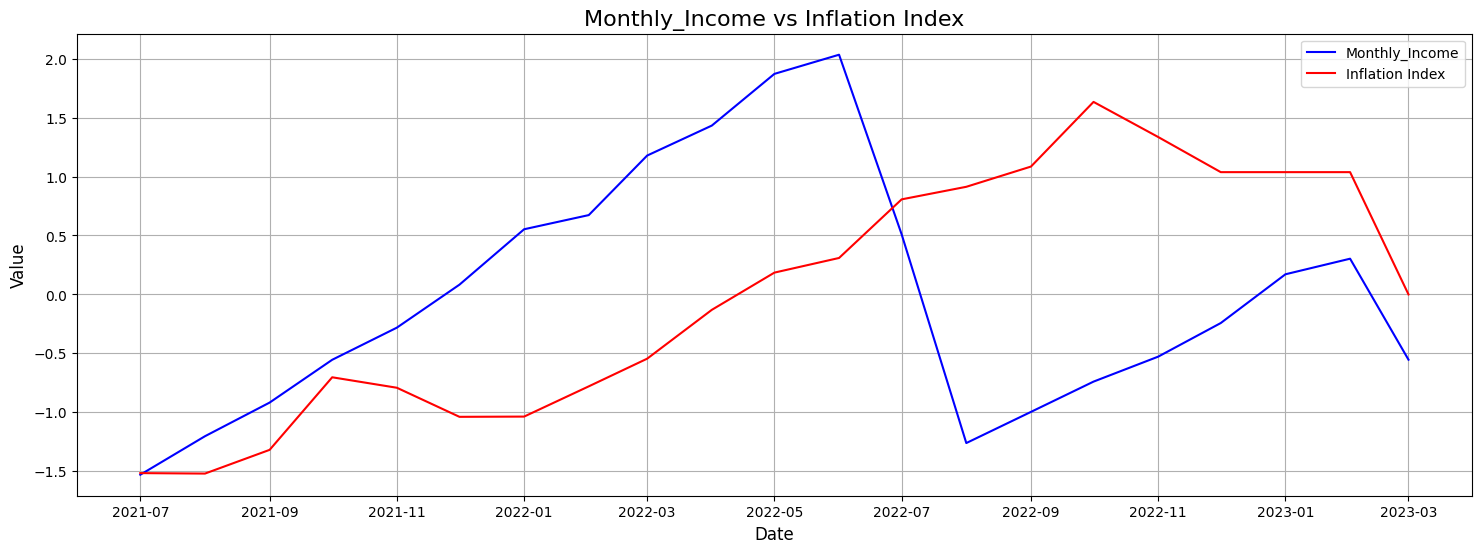

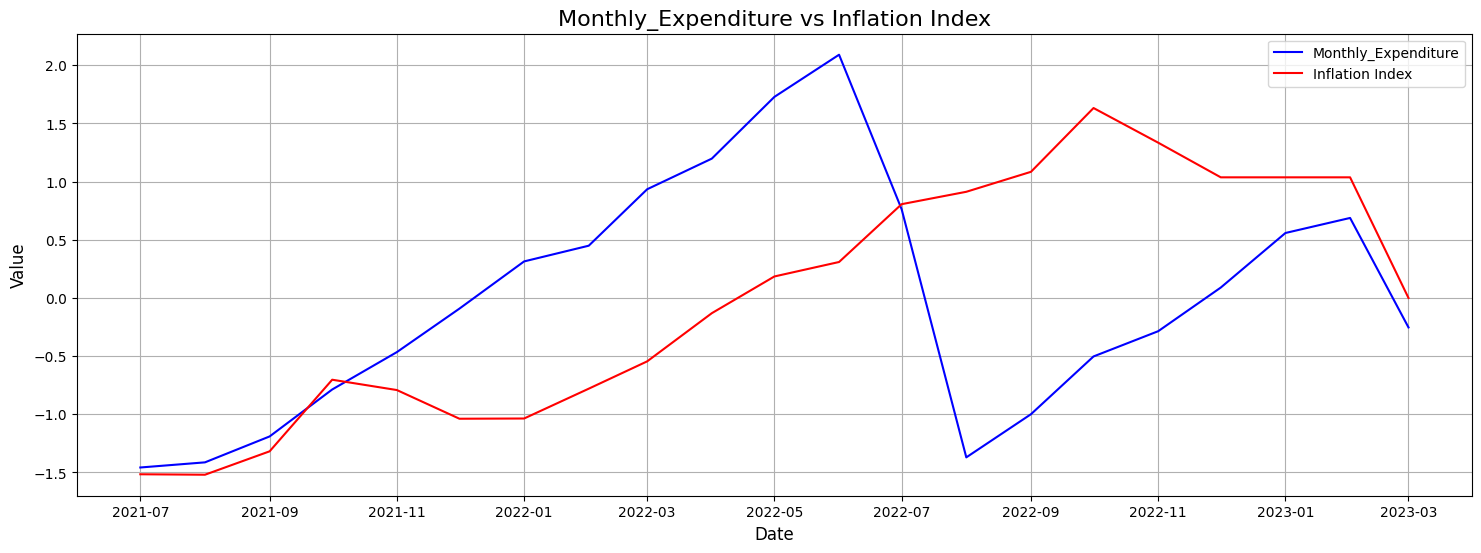

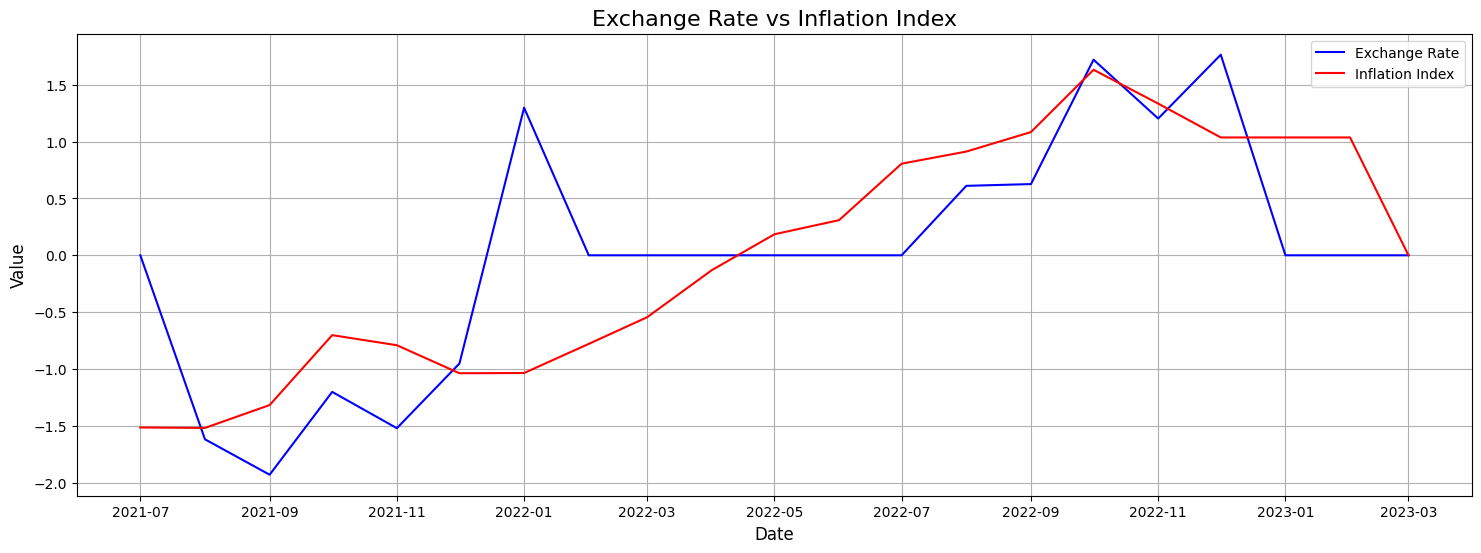

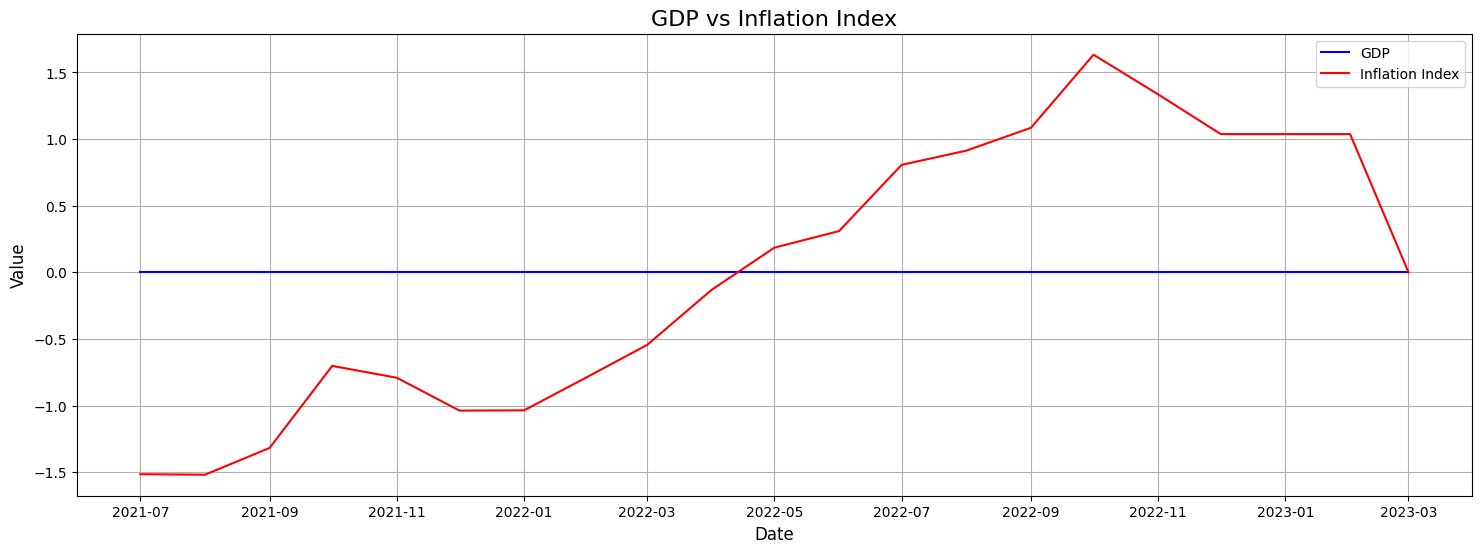

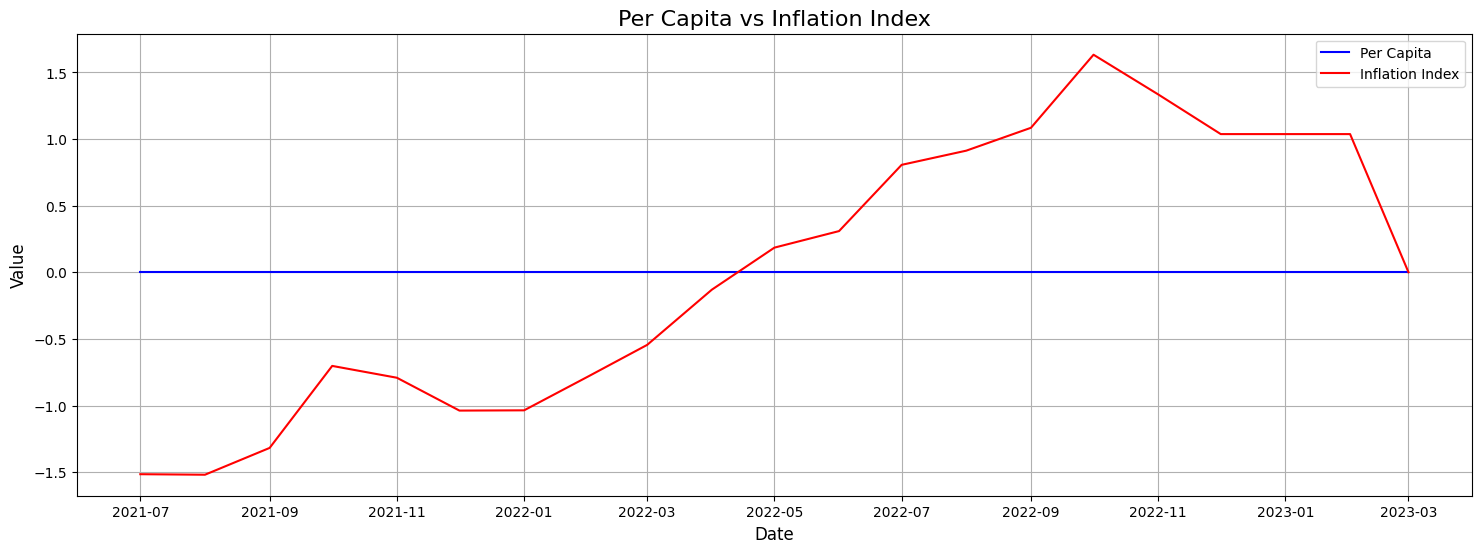

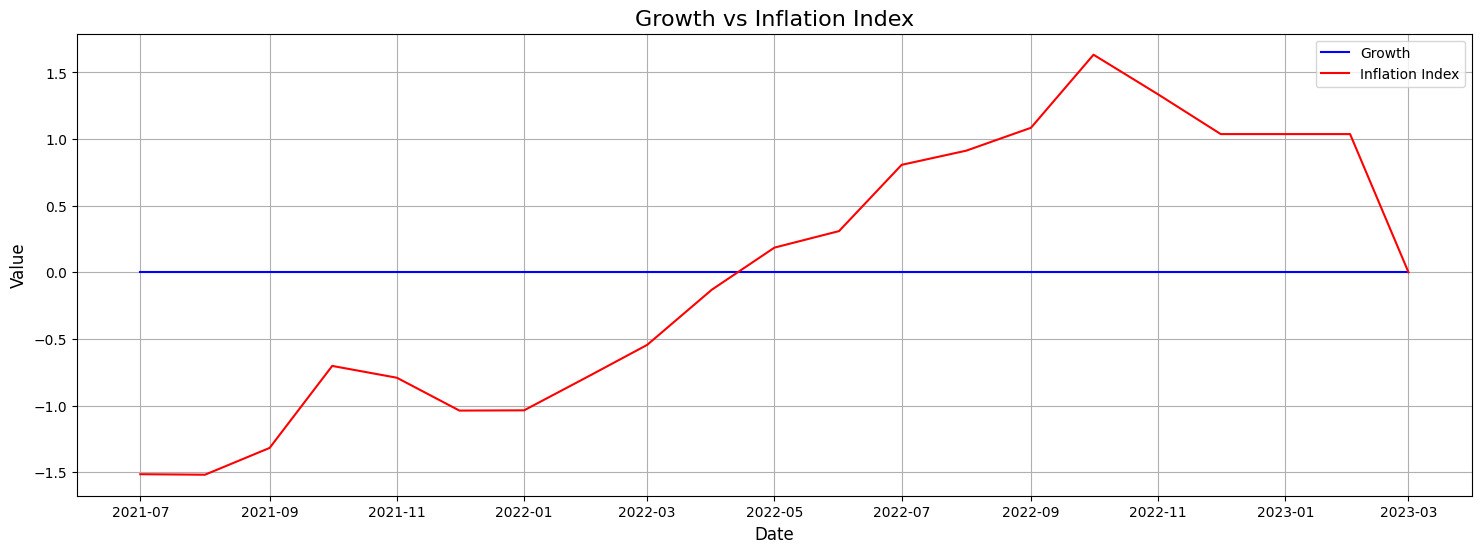

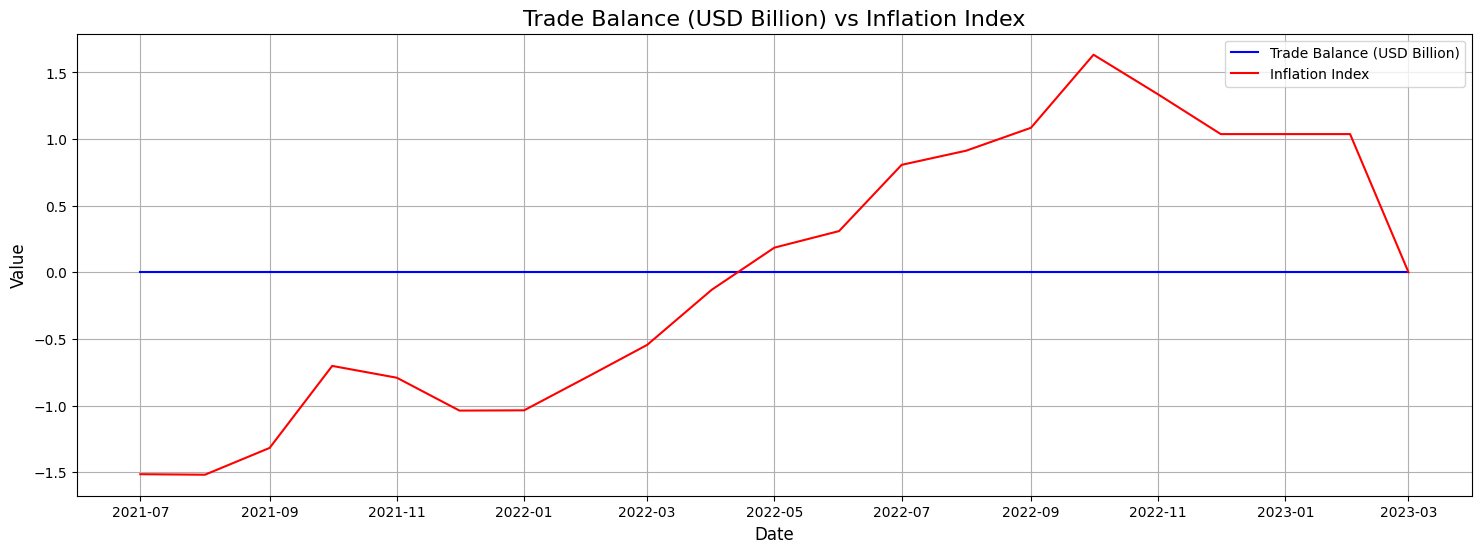

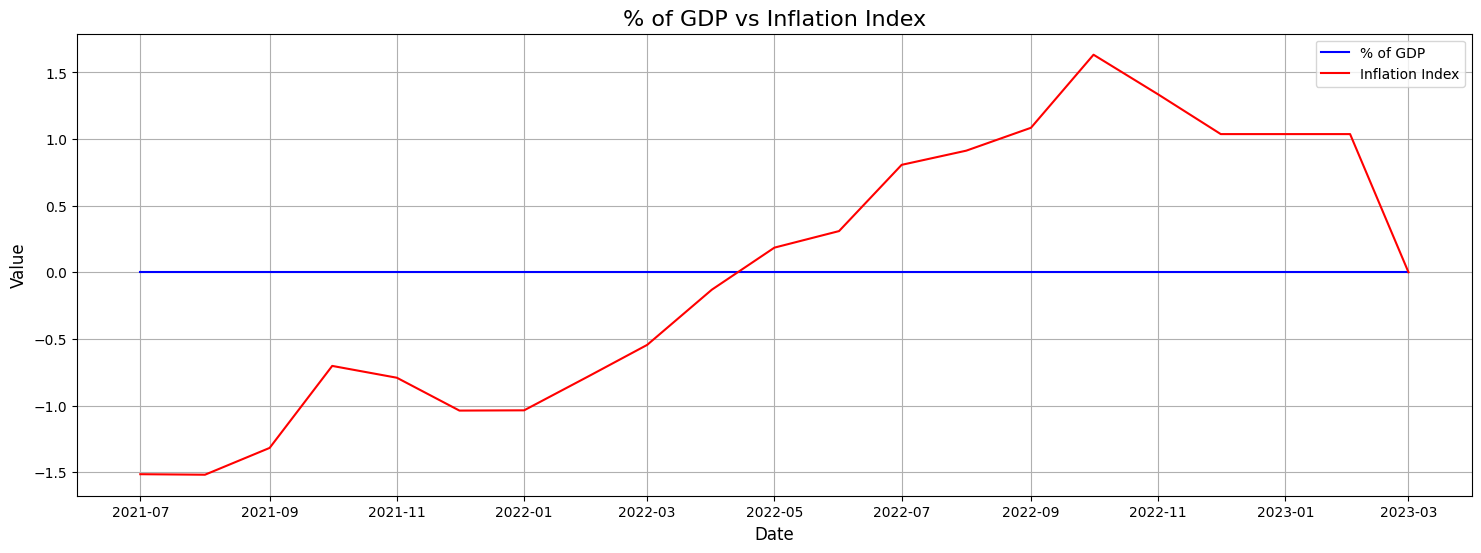

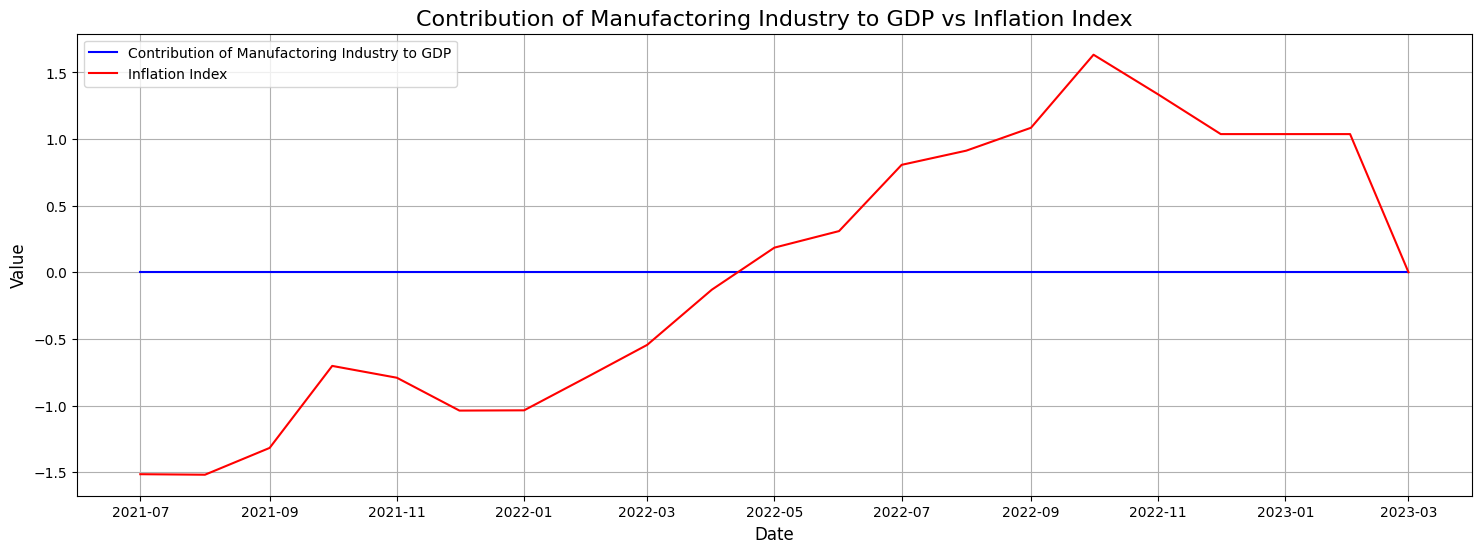

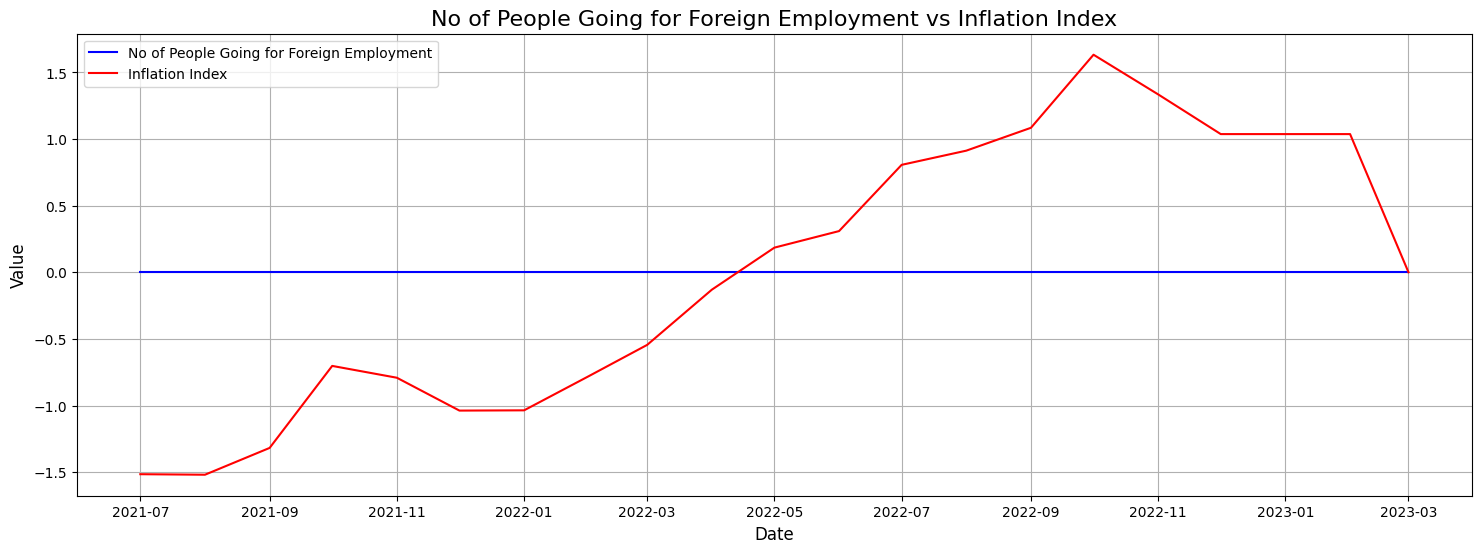

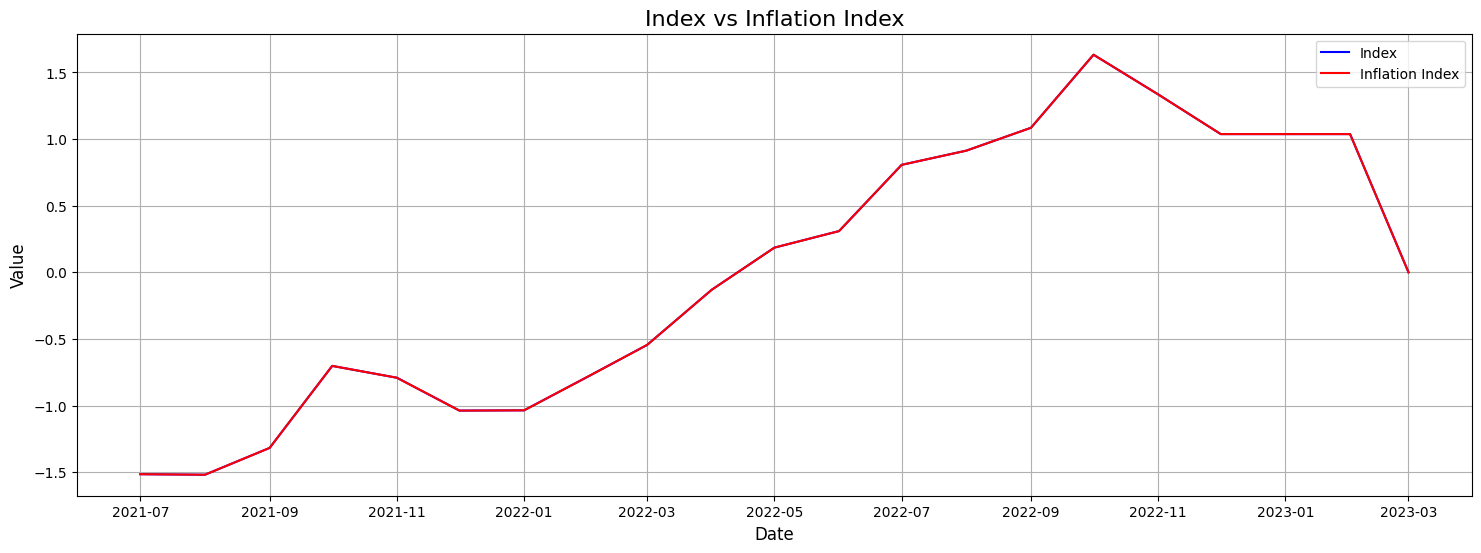

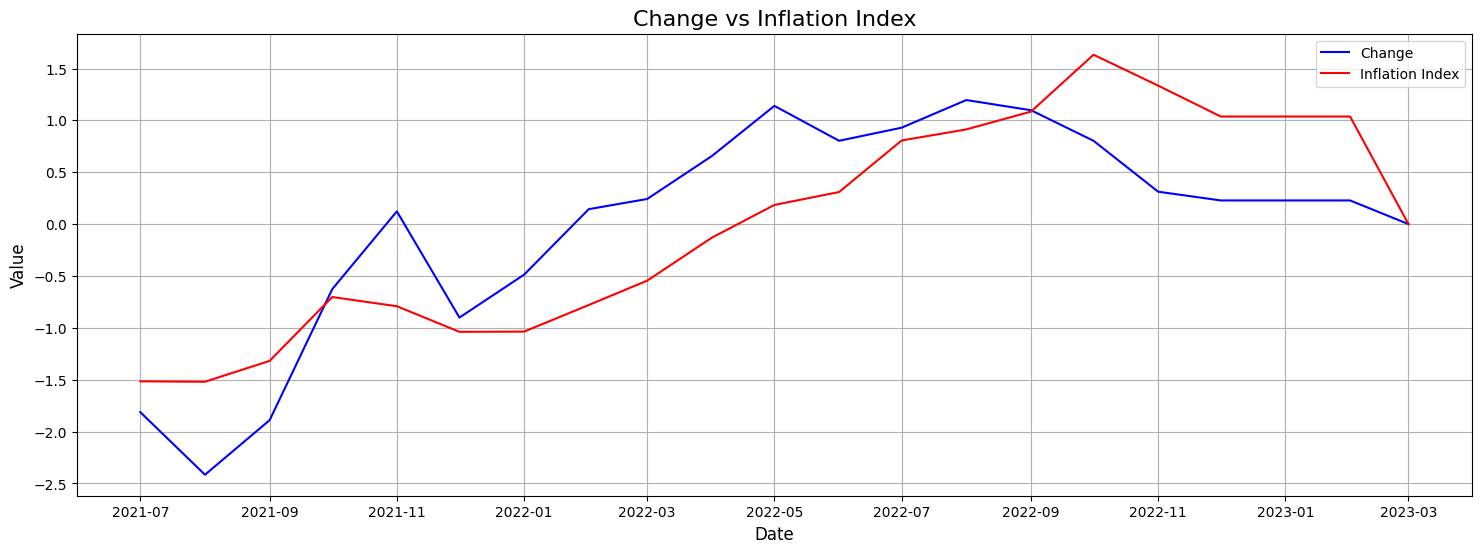

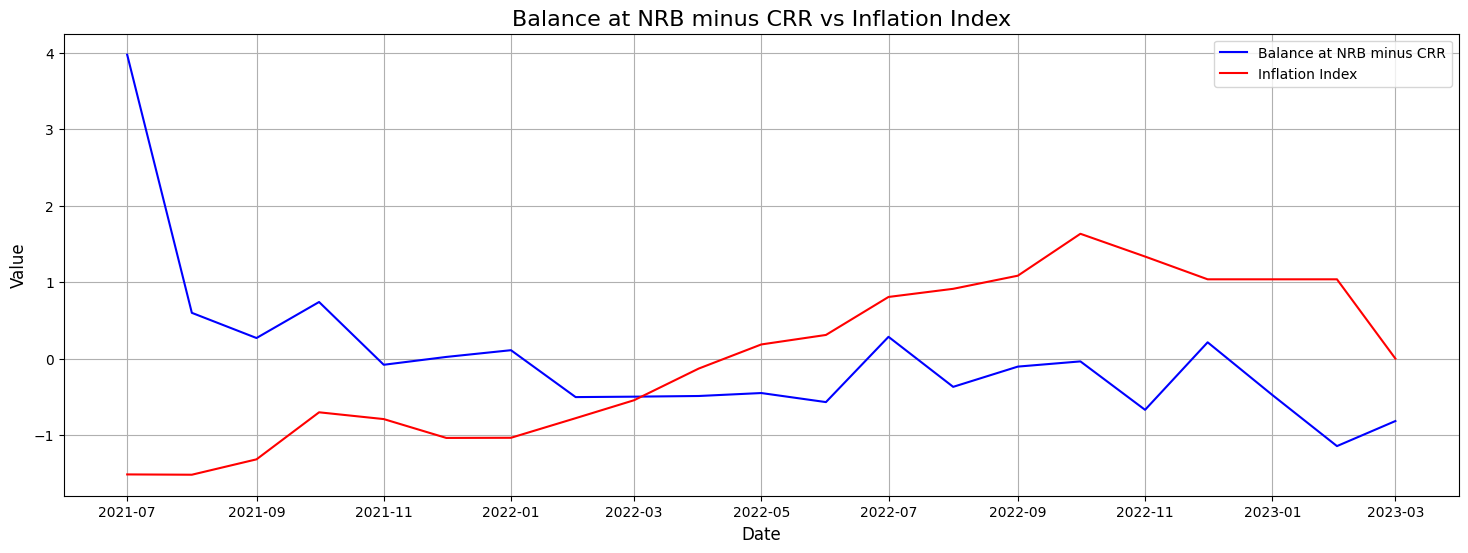

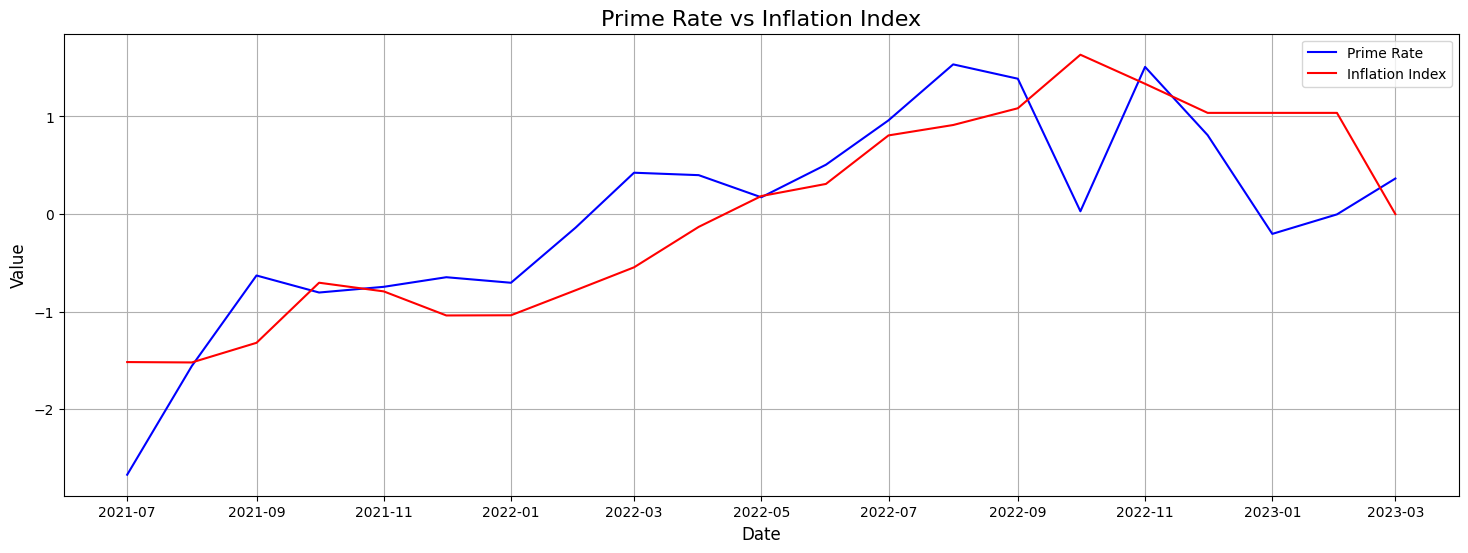

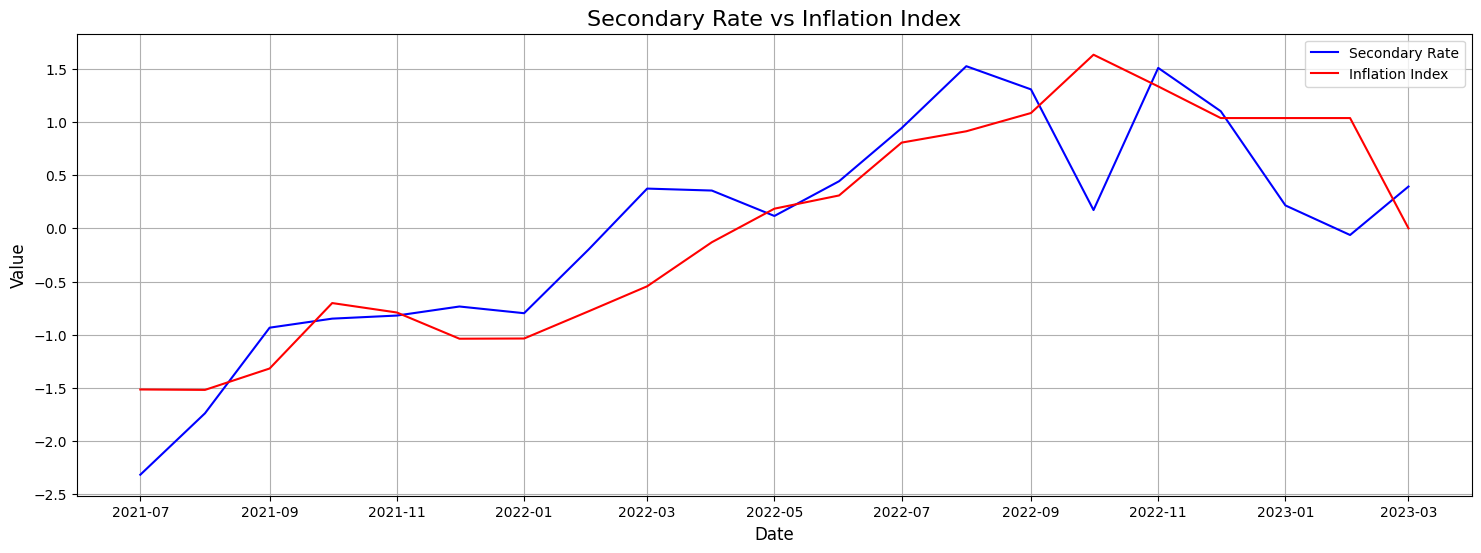

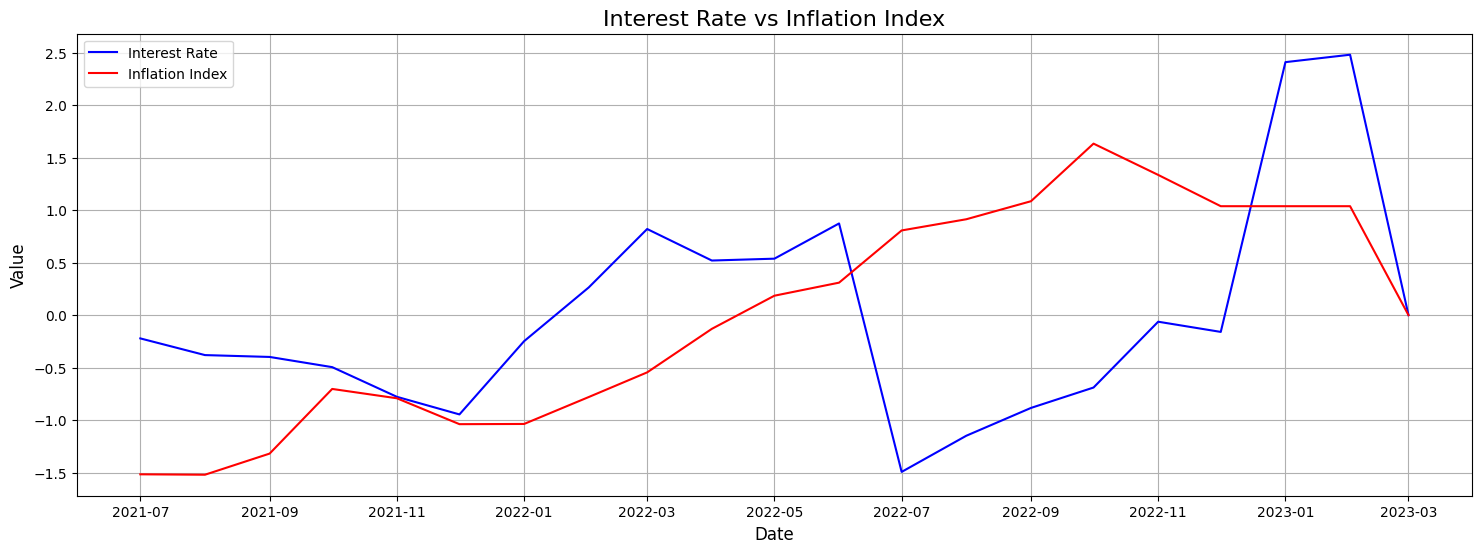

In [110]:
import matplotlib.pyplot as plt

for column in df_scaled.columns:
    plt.figure(figsize=(18, 6))
    plt.plot(df_scaled.index, df_scaled[column], label=column, color='blue')
    plt.plot(df_scaled.index, df_scaled['Index'], label= 'Inflation Index', color='red')
    plt.title(f'{column} vs Inflation Index', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend()
    plt.grid()
    plt.show()


- If we look at the line charts of each of the variables against the Inflation Index it is visible that the Secondary Rate is most correlated with inflations in that it most closely parallels the Inflation Index. Also, there are positive influence of the Change and Prime Rate on inflation rate as indicated by the positive trend in the figures. The Exchange Rate follows with a close relationship that suggests that change in value of currencies cause inflation. On the other hand, there is a relatively moderate positive correlation with some variable such as Balance at NRB minus CRR and Monthly Expenditure. The graphs of the line charts show that Interest Rate, Monthly Income and other economic factors including GDP, Per Capita and other indicator of trade have no apparent pattern with the Inflation Index.This may be because of there could be external economic or geopolitical factors influencing inflation that are not captured by the variables in the dataset, affecting the strength of the relationship with inflation.

### Correlation Analysis using heatmap and RFE

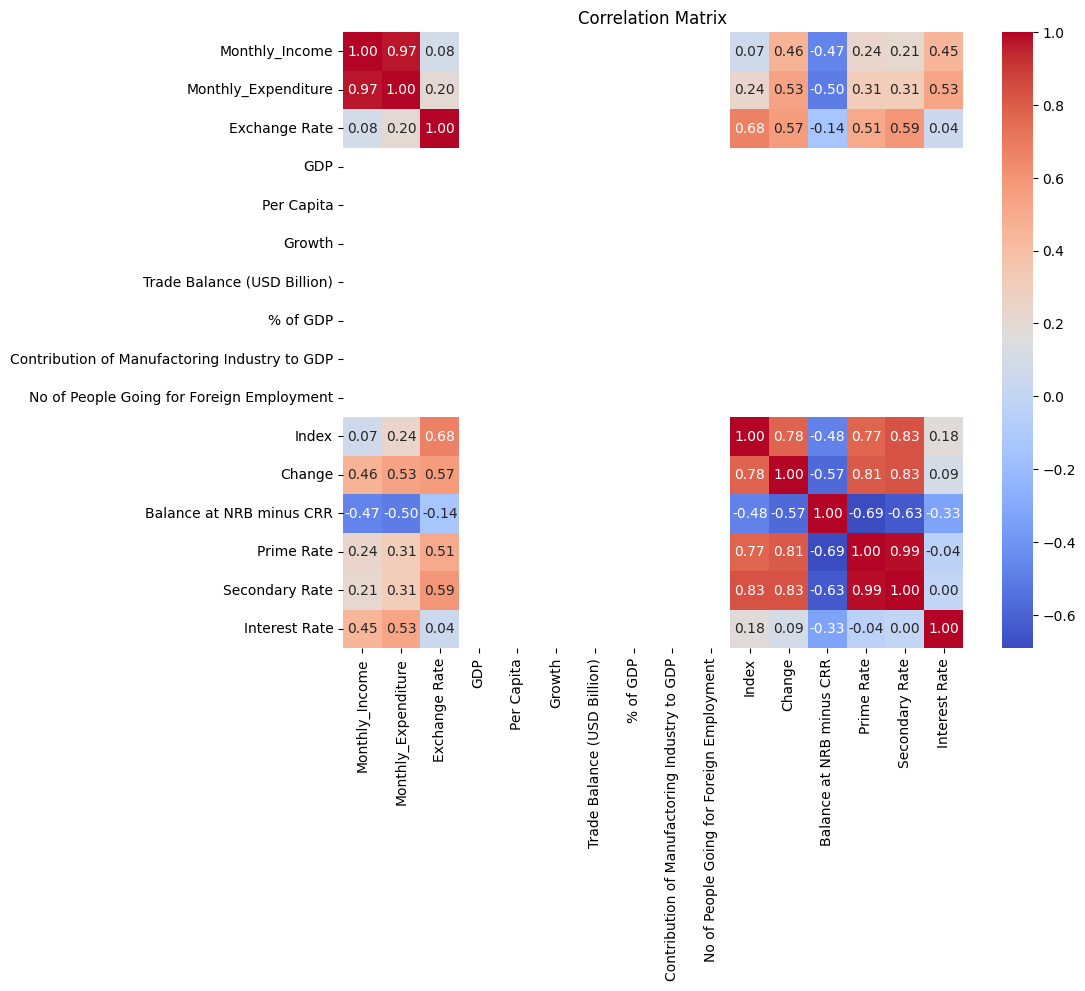

In [111]:
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE


# Compute the correlation matrix
corr_matrix = df_scaled.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### Feature Selection

In [112]:
# Select features based on correlation with the target (Inflation Index)
target_variable = 'Index'
correlation_with_target = df_scaled.corr()[target_variable].abs().sort_values(ascending=False)
print("Correlation with target variable (Inflation Index):\n", correlation_with_target)

# Use RFE for feature selection
X = df_scaled.drop(columns=[target_variable])
y = df_scaled[target_variable]
rfe = RFE(LinearRegression(), n_features_to_select=10).fit(X, y)

# Display selected features
selected_features = X.columns[rfe.support_]
print("\nSelected features:", selected_features)

Correlation with target variable (Inflation Index):
 Index                                            1.000000
Secondary Rate                                   0.830907
Change                                           0.775715
Prime Rate                                       0.769968
Exchange Rate                                    0.675405
Balance at NRB minus CRR                         0.478510
Monthly_Expenditure                              0.239482
Interest Rate                                    0.179694
Monthly_Income                                   0.068403
GDP                                                   NaN
Per Capita                                            NaN
Growth                                                NaN
Trade Balance (USD Billion)                           NaN
% of GDP                                              NaN
Contribution of Manufactoring Industry to GDP         NaN
No of People Going for Foreign Employment             NaN
Name: Index, dtype:

In [113]:
print(df_scaled.isnull().sum())

Monthly_Income                                   0
Monthly_Expenditure                              0
Exchange Rate                                    0
GDP                                              0
Per Capita                                       0
Growth                                           0
Trade Balance (USD Billion)                      0
% of GDP                                         0
Contribution of Manufactoring Industry to GDP    0
No of People Going for Foreign Employment        0
Index                                            0
Change                                           0
Balance at NRB minus CRR                         0
Prime Rate                                       0
Secondary Rate                                   0
Interest Rate                                    0
dtype: int64


- Here, GDP and rest of the lower column is showing NaN because of constant column. Also from the code above ``df_scaled.isnull().sum()`` shows there are no missing values.

### Splitting into Train and Test

In [114]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
# Use only the selected features for model training
X_selected = X[selected_features]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)



### Regression Model Selection

- For forecasting inflation, we experimented with three machine learning models: The three models include ``Linear Regression``, ``Random Forest`` and ``Gradient Boosting``. Linear Regression is useful in making sure that the features and the target variable share a ratio of one to one. Random Forestes constructs many trees and then makes a decision by averaging the results of the trees constructed, thereby minimizing overfitting. Gradient Boosting enhances model’s prediction capacity by making corrections step by step from the previous model.



- For the purpose of assessing the models demonstrated we need overall metrics such as ``RMSE (Root Mean Squared Error)``, ``MAE (Mean Absolute Error)``, and ``R²``. ``RMSE`` informs us how far from reality the predictions are and the smaller the value the better. ``MAE`` provides the average mistake, while ``R²`` determines how much deviance within the data the collected model accounts for. 

- Linear Regression Model

In [115]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Building and evaluating Linear Regression Model
# Initialize and train a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate models
def evaluate_model(y_test, y_pred, model_name):
    print(f"--- {model_name} ---")
    print("-------------------------------------")
    print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_pred))}")
    print("-------------------------------------")
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred)}")
    print("-------------------------------------")
    print(f"R^2: {r2_score(y_test, y_pred)}\n")

evaluate_model(y_test,y_pred_lr,"LinearRegression")

--- LinearRegression ---
-------------------------------------
Root Mean Squared Error (RMSE): 0.92666170760422
-------------------------------------
Mean Absolute Error (MAE): 0.6975856815438275
-------------------------------------
R^2: 0.4935767879280166



- Random Forest

In [116]:
from sklearn.ensemble import RandomForestRegressor
# Building and evaluating Random Forest Regressor
# Initialize and train a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model (using Mean Squared Error)
evaluate_model(y_test,y_pred_rf,"Random Forest Regression")


--- Random Forest Regression ---
-------------------------------------
Root Mean Squared Error (RMSE): 0.5783530882034911
-------------------------------------
Mean Absolute Error (MAE): 0.5209520470118925
-------------------------------------
R^2: 0.8027317067195164



- Gradient Boosting Regressor

In [117]:
from sklearn.ensemble import GradientBoostingRegressor

# Building and Evluating Gradient Boosting Regressor
grb_model = GradientBoostingRegressor(random_state=42)
grb_model.fit(X_train, y_train)

# Make Predictions on test
y_pred_grb = grb_model.predict(X_test)

# Evaluating the model
evaluate_model(y_test,y_pred_grb,"Gradient Boosting Regression")

--- Gradient Boosting Regression ---
-------------------------------------
Root Mean Squared Error (RMSE): 0.5531072141530694
-------------------------------------
Mean Absolute Error (MAE): 0.49010088971851556
-------------------------------------
R^2: 0.8195778659674781



### Hyper-Parameter tuning

After model selection and training, here i adjusted or fine tuned the settings of a given machine learning model for better accuracy which is also called hyper-parameter tuning. While model parameters are derived from data used in training often iteratively, hyperparameters have to be set before the training process and their values can greatly affect the latter’s performance. The method I used here for Hyperparameter tuning is GridSearchCv which autometes the process of tuning.


- Here Linear Regression isnt included because it doesnot have hyper parameters to tune.

In [118]:
from sklearn.model_selection import GridSearchCV #Automates the process of hyperparameter tuning
# Models and hyperparameters
models_and_params = {
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            # 'min_samples_leaf': [1, 2, 4]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 10],
            # 'min_samples_split': [2, 5, 10], 
            # 'min_samples_leaf': [1, 2, 4]
        }
    }
}

# Tune models
best_models = {}
for name, item in models_and_params.items():
    grid_search = GridSearchCV(item['model'], item['params'], cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


Here, 
1. For Random Forest: ``n_estimators`` decides the number of trees in the forest, and maximum value achieves better result but it takes time to process, where ``max_depth`` restrict the depth of trees to avoid over-fitting problems, ``min_samples_split`` decides minimum sample required to split one node.
2. For Gradient Boosting: ``n_estimators`` is the number of boosting stages (decision trees), and usually, more trees are better because they fit the model better; ``learning_rate`` controls, how much a single decision tree influences the final result, which is helpful when using a great number of decision trees; ``max_depth`` prevents a single decision tree from being too complex when it tries to overfit data.
(Also there are more hyperparameters for both)

### Selecting the Best Model

In [119]:
# Selecting the best model
best_model = max(best_models.items(), key=lambda x: r2_score(y_test, x[1].predict(X_test)))
print(f"The best model is {best_model[0]} with R^2: {r2_score(y_test, best_model[1].predict(X_test))}")

The best model is Gradient Boosting with R^2: 0.8195744937529927


### Predicting Future Inflation 

In [130]:
# Prepare future features with added variability
future_dates = pd.date_range(start='2021-03-01', end='2026-12-31', freq='MS')
mean_values = df_scaled[selected_features].mean()
variability = np.random.normal(0, 0.1, (len(future_dates), len(selected_features)))
# Adding noise -> to prevent overfitting by making the model focus on the underlying patterns rather than memorizing the exact data points.

# Creating future feature DataFrame with variability
future_features = pd.DataFrame(mean_values.values + variability, index=future_dates, columns=selected_features)

# Scaling the future features using the same scaler
scaler = StandardScaler().fit(df_scaled[selected_features])  # Fit on existing data
future_features_scaled = scaler.transform(future_features)


C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


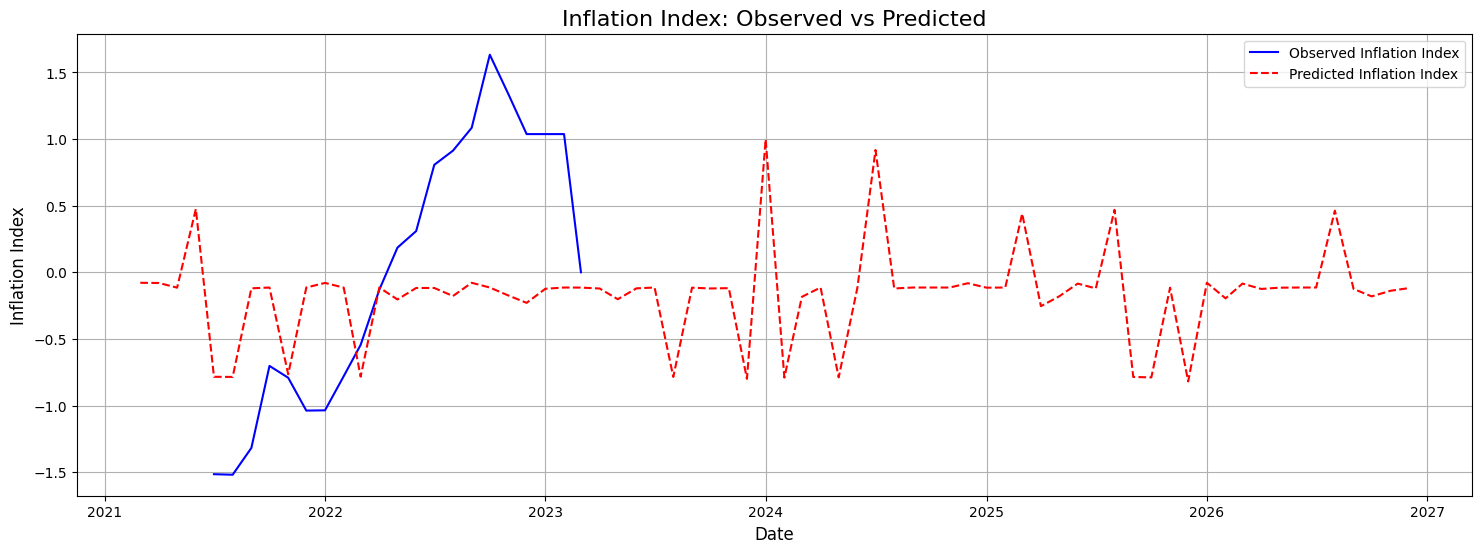

In [131]:
# Predicting future inflation index
future_predictions = grb_model.predict(future_features_scaled)

# Plot Line Chart for observed vs predicted inflation
plt.figure(figsize=(18, 6))
plt.plot(df_scaled.index, df_scaled['Index'], label='Observed Inflation Index', color='blue')
plt.plot(future_dates, future_predictions, label='Predicted Inflation Index', color='red', linestyle='--')
plt.title('Inflation Index: Observed vs Predicted', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Inflation Index', fontsize=12)
plt.legend()
plt.grid()
plt.show()

The above line graph, titled "Inflation Index: Inflation, compare actual and predicted indices over a specific period. On the X-axis is the time line of year 2021-2027 while the Y-axis indicates the inflation index scale from -1.5 to 1.5. On the same graph, a solid blue line representing the observed inflation index shows real data of 2021-2023 March where the inflation reached its peak during 2023 and then declined steeply. The predicted inflation index is shown as a red dashed line moving around zero and having several peak and troughs during 2021-2027.